# Set up Enironment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import the *.csv files

In [2]:
# While importing change the timestamp variable to datetime by inserting the parse_dates option
user_df = pd.read_csv('C:/Users/freta/Desktop/relax_challenge/takehome_users.csv', encoding='latin-1')

engage_df = pd.read_csv('C:/Users/freta/Desktop/relax_challenge/takehome_user_engagement.csv', index_col='time_stamp', parse_dates=True)

In [3]:
engage_df.head()

# Here we have a parsed datetime index with two columns
# The value of the 'visited' variable is 1 across all observations

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [4]:
# group by user_id and aggregate it to weekly form

engage_agg=engage_df.groupby('user_id').resample('1W').sum()

In [5]:
# remove those with missing values that resulted from the agregation
# drop the duplicate 'user_id column' that was created after we use the groupby statement

agg_clean = engage_agg[engage_agg['user_id'].isnull()==False].drop('user_id',axis=1)
agg_clean.head(10)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1

In [6]:
#remove weeks that had less than 3 visits for all users

active = agg_clean['visited']>=3

#Groups by users and sums up the number of weeks that had 3 or more visits

active = active.groupby(level=0).apply(np.sum)

#removes users with no weeks that had 3 or more visits

active = active[active!=0]
active_users = pd.DataFrame(active,index=active.index)
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [7]:
# Let's merge with our second dataset

act_user_data = active_users.merge(user_df,left_index=True,right_on='object_id',how='inner')

# Create new column called 'Active' and assign the value 1 to indicate all the users in this subset were active

act_user_data['Active']=1

#Add Active column to origional Data

user_df['Active']=int(0)
user_df.iloc[list(act_user_data.index),10]=1
model_data = user_df.set_index('object_id').sort_index()

# remove unecessary features

model_data = model_data.drop([ 'name', 'email','last_session_creation_time',],axis=1)
date_feature = model_data.pop('creation_time')
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [8]:
# The 'invited_by_user_id' varaible is the only one with missing values. Thus let's fill it with 0
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)

# Assign 0 to 0 and other values to 1
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)

# Handle categorical variables by using pandas get_dummies

model_data = pd.get_dummies(data=model_data,columns=['creation_source'])

In [9]:
# Handle the other categorical variable 'org_id'

org = model_data.groupby('org_id').sum()

org_cata = []
for i in model_data['org_id']:
    cata = org.loc[i,'Active']
    org_cata.append(cata)
model_data['org_id'] = org_cata

model_data = pd.get_dummies(data=model_data,columns=['org_id'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
model_data.info()

# We have 12000 observations and 25 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 25 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
invited_by_user_id                    12000 non-null int64
Active                                12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
org_id_0                              12000 non-null uint8
org_id_1                              12000 non-null uint8
org_id_2                              12000 non-null uint8
org_id_3                              12000 non-null uint8
org_id_4                              12000 non-null uint8
org_id_5                              12000 non-null uint8
org_id

Active                                1.000000
org_id_5                              0.059582
org_id_6                              0.057128
creation_source_GUEST_INVITE          0.043657
org_id_12                             0.032859
creation_source_SIGNUP_GOOGLE_AUTH    0.031432
invited_by_user_id                    0.022735
org_id_7                              0.021869
org_id_4                              0.016279
creation_source_SIGNUP                0.016004
opted_in_to_mailing_list              0.010339
org_id_3                              0.007948
org_id_8                              0.007735
org_id_10                             0.007492
enabled_for_marketing_drip            0.005901
org_id_16                             0.004317
org_id_9                              0.002004
creation_source_ORG_INVITE           -0.011376
org_id_13                            -0.019385
org_id_2                             -0.023874
org_id_14                            -0.026086
org_id_11    

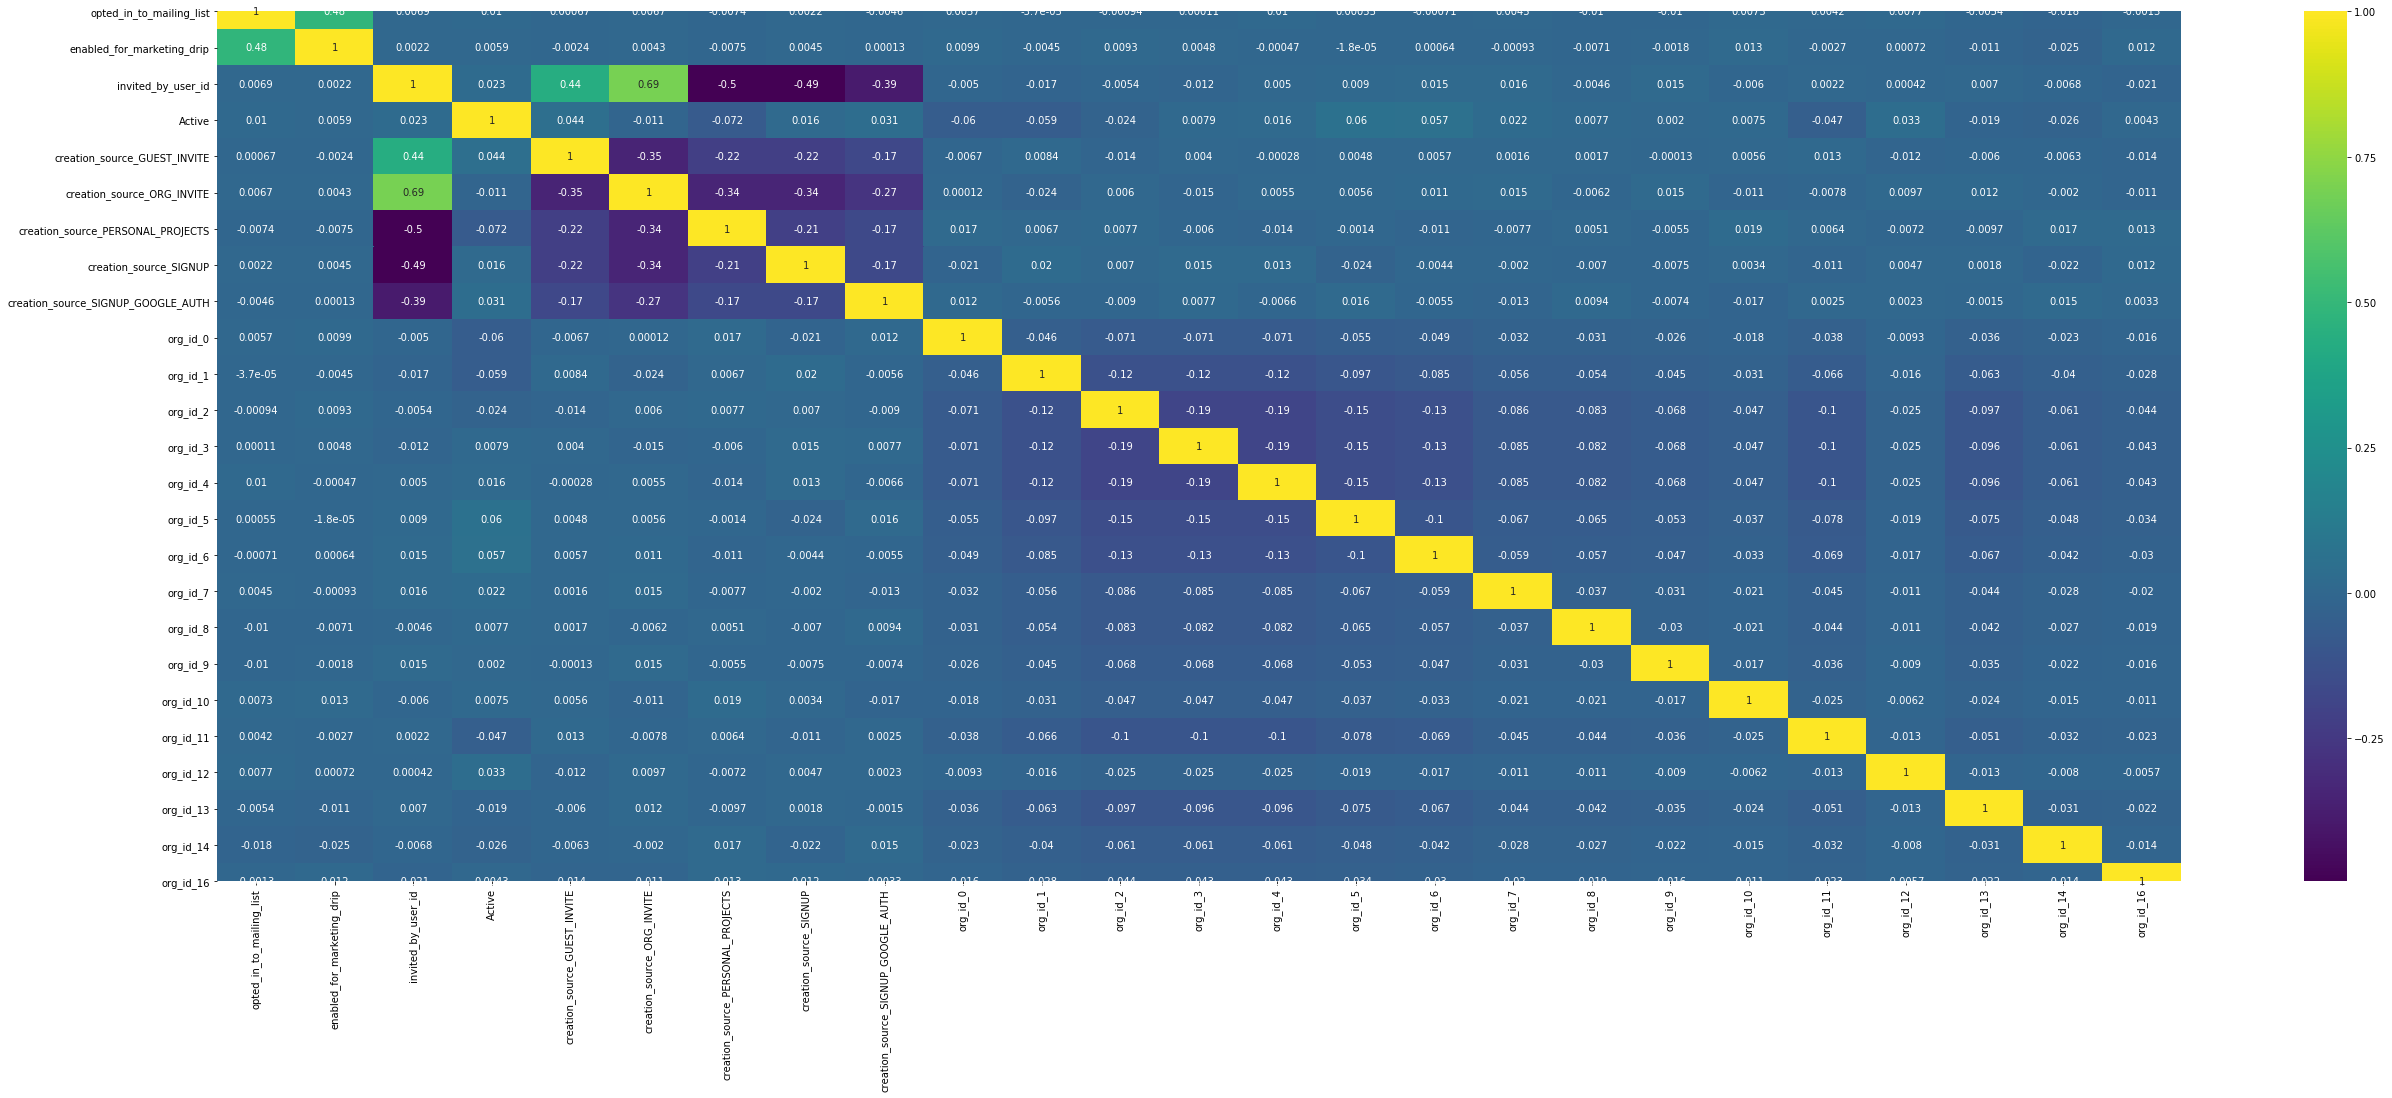

In [11]:
#  Check correlation 

plt.figure(figsize=(44,16))
cm=model_data.corr()

sns.heatmap(cm, annot=True, cmap='viridis')
cm['Active'].sort_values(ascending=False)

## Split into 70%-30%

In [12]:
from sklearn.model_selection import train_test_split
# Separate the label from the features
model_data=model_data.astype('int')
y = model_data['Active']
X = model_data.drop('Active', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# We split our dataset correctly


((8400, 24), (3600, 24), (8400,), (3600,))

# Model

In [14]:
# Import the necessary machine learning tools

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import  GridSearchCV

## 1. Random Forest Classifier

In [15]:
# Instantiate model

rf = RandomForestClassifier()

# Specify the hyperparameter to be tunned

param = {'n_estimators' : [40, 50, 100, 150, 200, 250, 300, 500, 1000],
        'max_depth': [8, 10, 12, 14, 16, 18, 20]}

# Create the GridSearchCV object

rf_cv = GridSearchCV(rf, param_grid=param, cv=5)

#  Fit to the training set

rf_cv.fit(X_train, y_train)

# predict the fitted data

rf_pred = rf_cv.predict(X_test)

# Compute and print metrics (accuracy score and classification_report) with the best model parameters


print('accuracy_score:', accuracy_score(y_test, rf_pred))

rf_proba = rf_cv.predict_proba(X_test)
print('Log Loss: ', log_loss(y_test, rf_proba))

print('confusion_matrix: \n', confusion_matrix(y_test, rf_pred))
print('classification report: \n', classification_report(y_test, rf_pred))
print("Tuned Model Parameters: {}".format(rf_cv.best_params_))



accuracy_score: 0.8791666666666667
Log Loss:  0.36014326963544185
confusion_matrix: 
 [[3165    4]
 [ 431    0]]
classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3169
           1       0.00      0.00      0.00       431

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600

Tuned Model Parameters: {'max_depth': 12, 'n_estimators': 250}


# 2. Gradient Boosting Classifier

In [16]:
# Instantiate model

gb = GradientBoostingClassifier(max_features='sqrt', random_state=37)

# Specify the hyperparameter to be tunned

parameters = {'n_estimators':[40,45,50,55,60],'learning_rate':[.01,0.02,0.03,0.04,0.05],
              'max_depth':[1,2,3,4,5]}

# Create the GridSearchCV object

gb_cv = GridSearchCV(gb, param_grid=parameters, cv=5)

#  Fit to the training set

gb_cv.fit(X_train, y_train)

# predict the fitted data

gb_pred = gb_cv.predict(X_test)


# Compute and print metrics (accuracy score and classification_report) with the best model parameters

                           
print('accuracy_score:', accuracy_score(y_test, gb_pred))    

gb_prob = gb_cv.predict_proba(X_test)
print('Log Loss: ', log_loss(y_test, gb_prob))

print('confusion_matrix: \n', confusion_matrix(y_test, gb_pred))
print('classification report: \n', classification_report(y_test, gb_pred))

print("Tuned Model Parameters: {}".format(gb_cv.best_params_))



accuracy_score: 0.8802777777777778
Log Loss:  0.35716499594401424
confusion_matrix: 
 [[3169    0]
 [ 431    0]]
classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3169
           1       0.00      0.00      0.00       431

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600

Tuned Model Parameters: {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 55}


C:\Users\freta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### - Gradient boosting is the one that performed the best with 88% accuracy logloss of 0.36. However the ROC_AUC score(0.5) is no t good result. 

In [17]:
# Re run the gradient boosting algorithm using the optimized hyper parameters
# Instantiate model 

gradb0 = GradientBoostingClassifier(max_features='sqrt', random_state=42, n_estimators=55, learning_rate=0.04, max_depth= 4)


#  Fit to the training set

gradb0.fit(X_train, y_train)

# predict the fitted data

y_pred_gradb0 = gradb0.predict(X_test)



print('accuracy_score:', accuracy_score(y_test, y_pred_gradb0))

gradb_prob0 =gradb0.predict_proba(X_test)
gradb_logloss0 = log_loss(y_test, gradb_prob0)
print(' Log Loss for the Gradient Boosting Classifier: ', gradb_logloss0)

print('confusion_matrix \n:', classification_report(y_test, y_pred_gradb0))
                               




accuracy_score: 0.8797222222222222
 Log Loss for the Gradient Boosting Classifier:  0.3574192070362591
confusion_matrix 
:               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3169
           1       0.00      0.00      0.00       431

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600



In [18]:
for name, importance in zip(X_train.columns, gradb0.feature_importances_):
    print(name, "=", importance)

opted_in_to_mailing_list = 0.03206182023543932
enabled_for_marketing_drip = 0.016399463599962822
invited_by_user_id = 0.014864110838675962
creation_source_GUEST_INVITE = 0.06698540966568797
creation_source_ORG_INVITE = 0.015476191267887593
creation_source_PERSONAL_PROJECTS = 0.13544441262446574
creation_source_SIGNUP = 0.019015254872901934
creation_source_SIGNUP_GOOGLE_AUTH = 0.02490411359906482
org_id_0 = 0.11928840280504853
org_id_1 = 0.1043335145880401
org_id_2 = 0.013172847321510913
org_id_3 = 0.005762825740283551
org_id_4 = 0.017886636601545026
org_id_5 = 0.1350990591858382
org_id_6 = 0.07803885010189869
org_id_7 = 0.004271406579539333
org_id_8 = 0.001004646782805331
org_id_9 = 0.0006447607992590242
org_id_10 = 0.000557759738475967
org_id_11 = 0.0890594086095693
org_id_12 = 0.06541794038328265
org_id_13 = 0.023405309534379422
org_id_14 = 0.01464373453032609
org_id_16 = 0.002262119994111591


# Visualizing Feature Importances using Gradient Boosting Algorithm

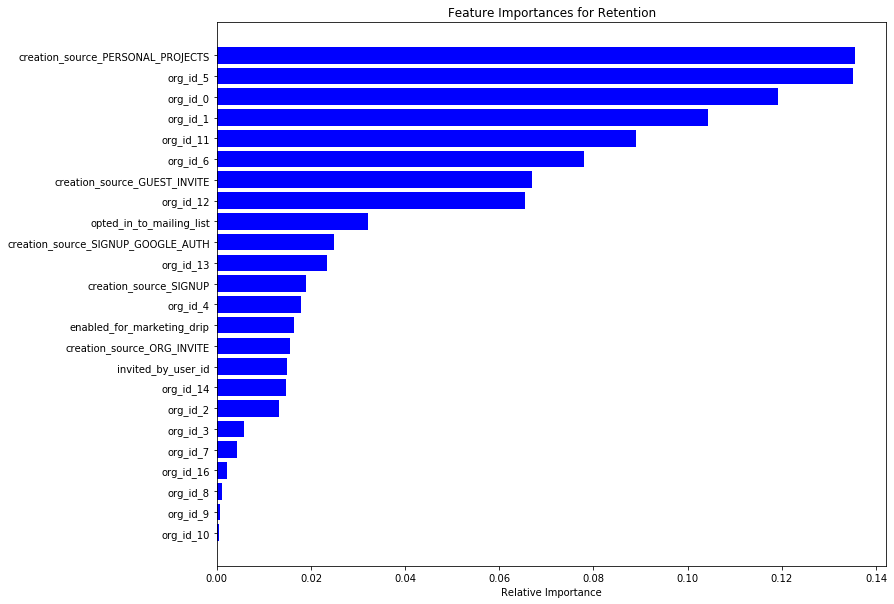

In [19]:
features = X_train.columns
importances = gradb0.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 10))
plt.title('Feature Importances for Retention')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()




### In sum, We got a good result from the Gradient boosting Model. " creation_source_PERSONAL_PROJECTS", "org_id_5"and "org_id_0" are the three most important features for the classification of active users and non active users. How ever, the recall and precision are not good enogh unlike the accuracy and log loss. Thus, this may result in higher false positivity rate.